In [30]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from itertools import cycle
from io import StringIO
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

8.182795165518002 13.182795165518002 threshold
7.970596633325218
8.312182206810059
7.606137417183748
8.213773343103123
32.81757385951683
7.421441361434403
9.042476149665465
7.70549510652634
9.190259106095654


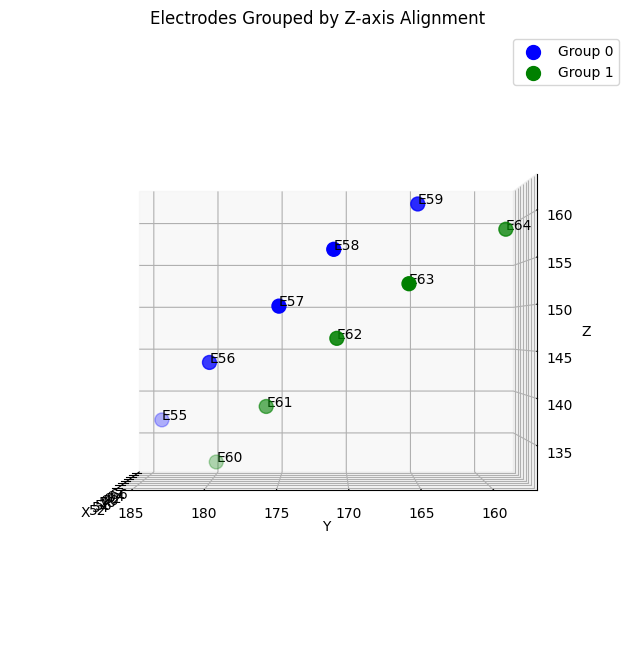

In [35]:
# electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_2024.csv")
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_electrodes_2024.csv")

filtered_df = electrode_df[electrode_df['label'] == 0]
sorted_df = filtered_df.sort_values(by='electrode_number')

distances = np.sqrt((np.diff(sorted_df['Z'])**2) + (np.diff(sorted_df['Y'])**2))

Q1, Q3 = np.percentile(distances, [25, 75])
IQR = Q3 - Q1
# Consider points within 1.5 * IQR as non-outliers
filtered_distances = distances[(distances >= Q1 - 1.5 * IQR) & (distances <= Q3 + 1.5 * IQR)]

z_threshold = np.mean(filtered_distances) + 5
print(np.mean(filtered_distances), z_threshold, 'threshold')

# Initialize a group label
group_label = 0
sorted_df['group'] = -1  

# Assign group labels
for i in range(len(sorted_df)):
    if i == 0:
        sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
    else:
        distance = np.sqrt((sorted_df.iloc[i]['Z'] - sorted_df.iloc[i-1]['Z'])**2 + (sorted_df.iloc[i]['Y'] - sorted_df.iloc[i-1]['Y'])**2)
        print(distance)
        if distance > z_threshold:
            group_label += 1
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
        else:
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label

# Plotting with color coding by group
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=0, azim=180)

unique_groups = sorted_df['group'].unique()
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

for group in unique_groups:
    group_df = sorted_df[sorted_df['group'] == group]
    color = colors[unique_groups.tolist().index(group)]
    ax.scatter(group_df['X'], group_df['Y'], group_df['Z'], s=100, color=color, label=f'Group {group}')
    for _, row in group_df.iterrows():
        ax.text(row['X'], row['Y'], row['Z'], f"E{row['electrode_number']}", color='black')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Electrodes Grouped by Z-axis Alignment')
plt.legend()
plt.show()

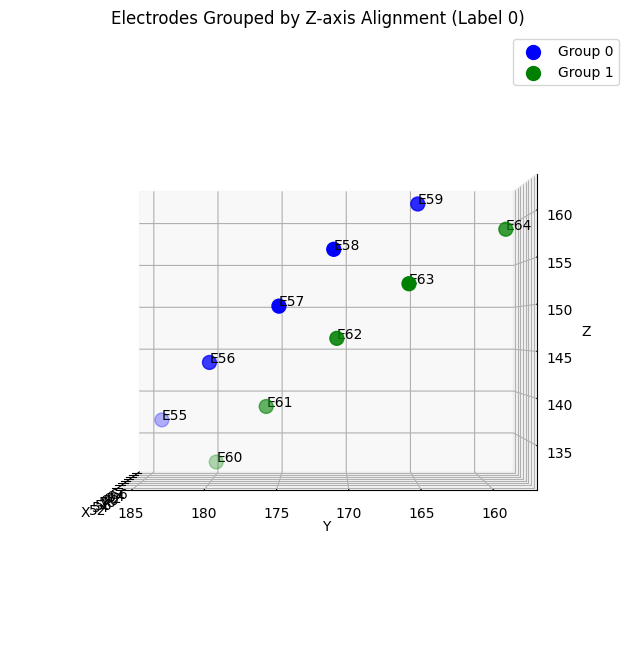

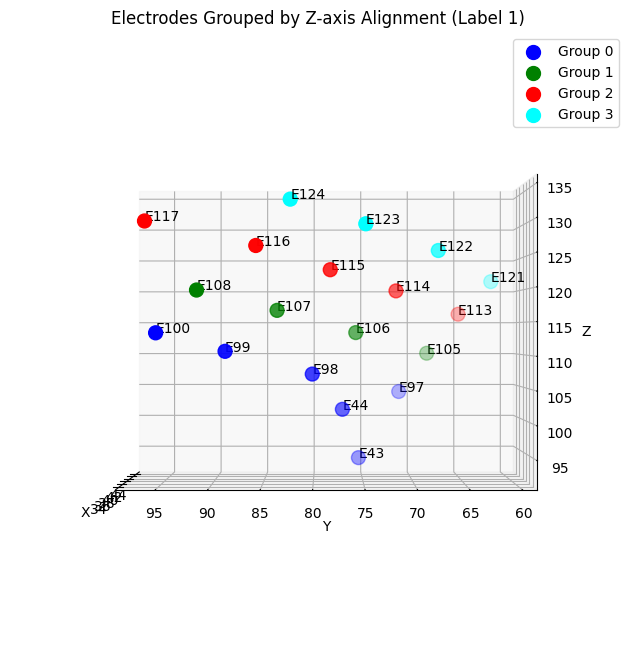

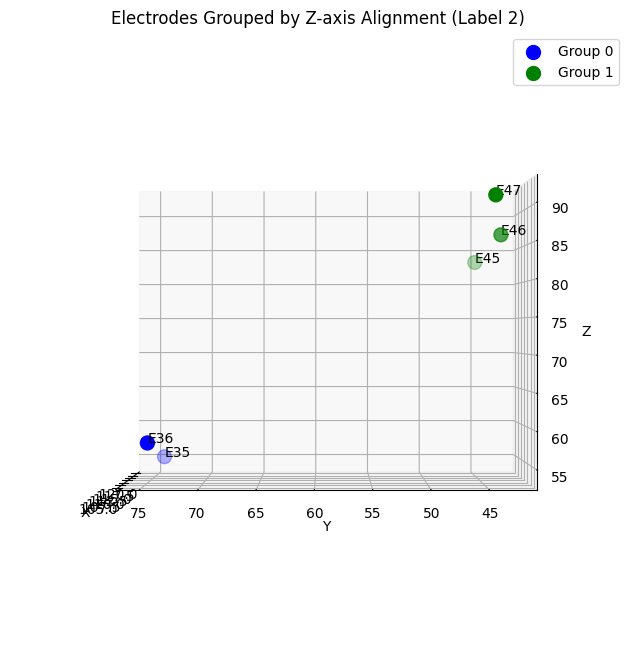

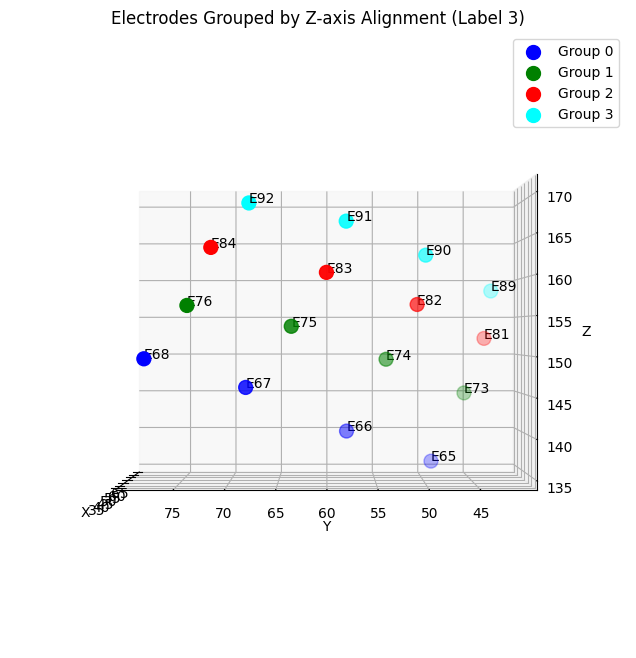

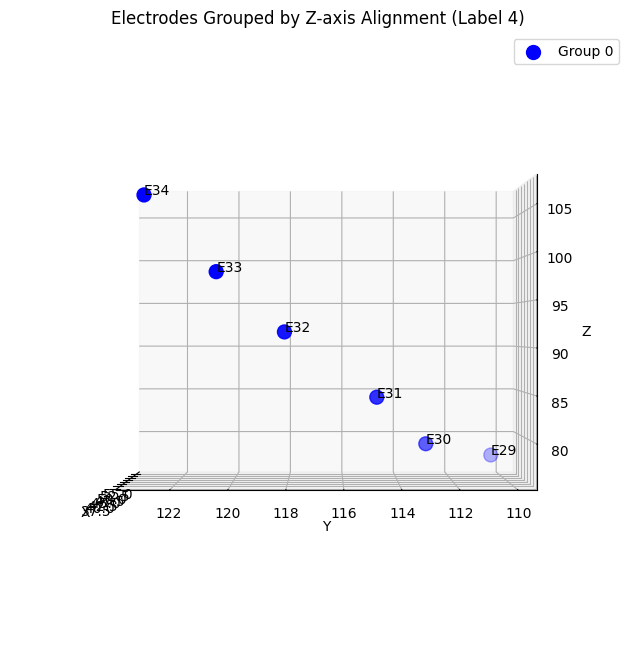

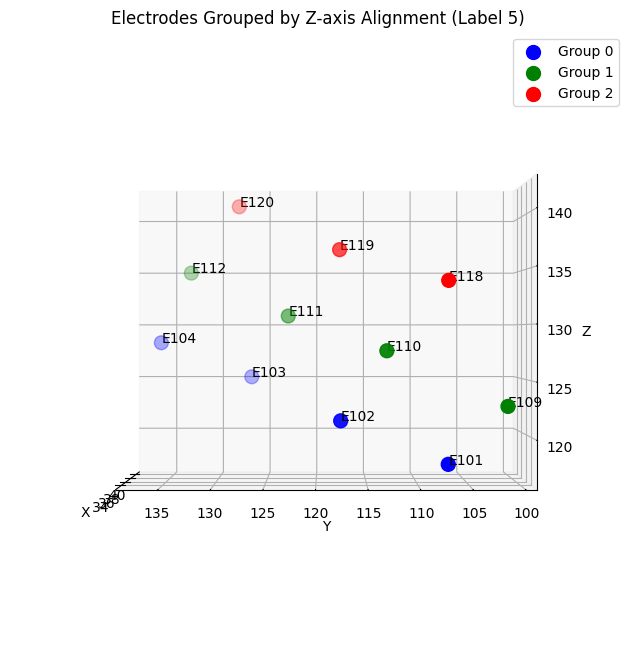

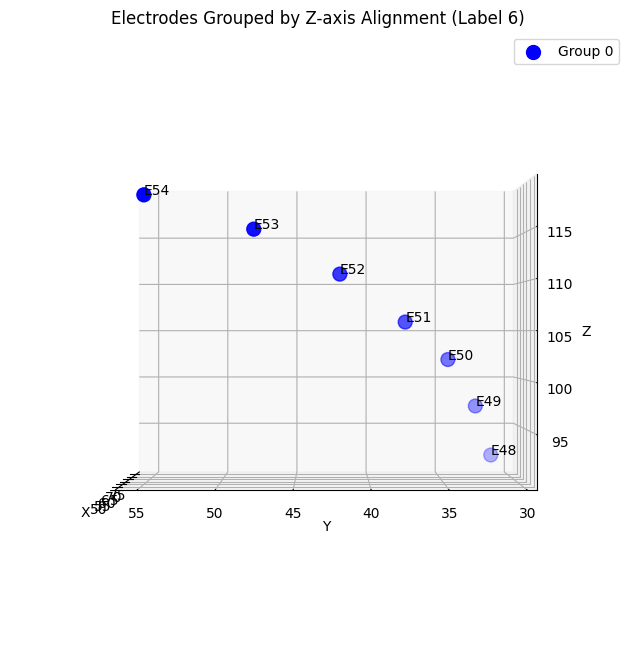

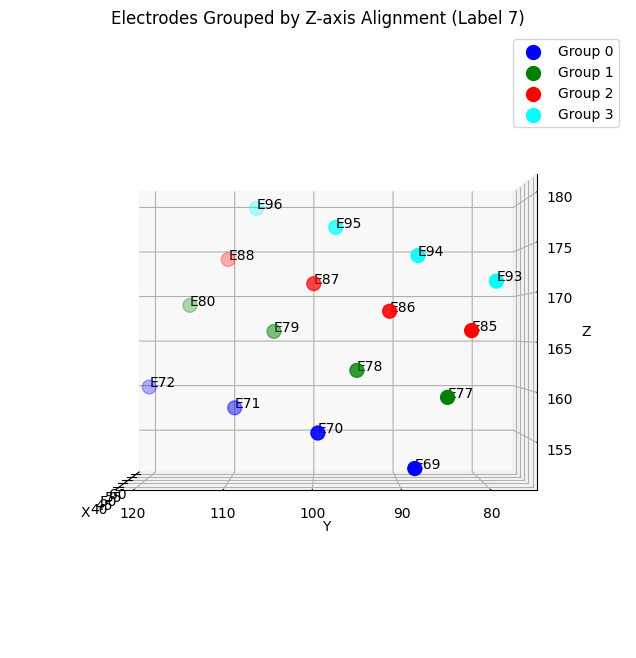

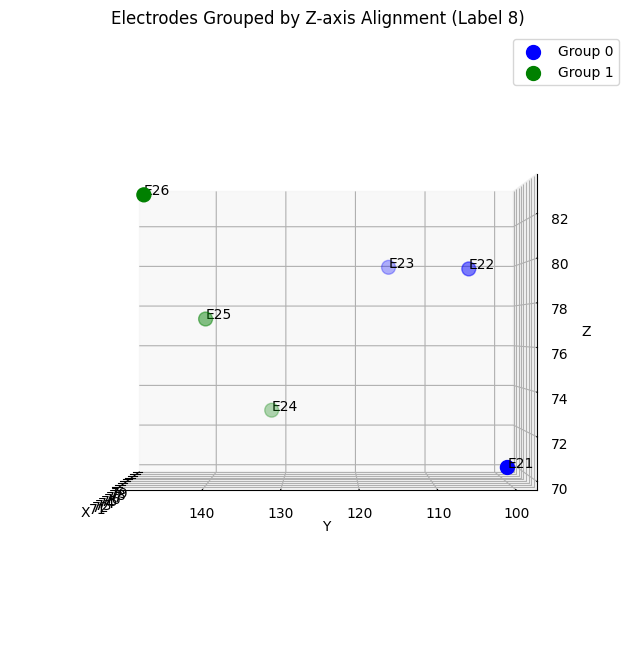

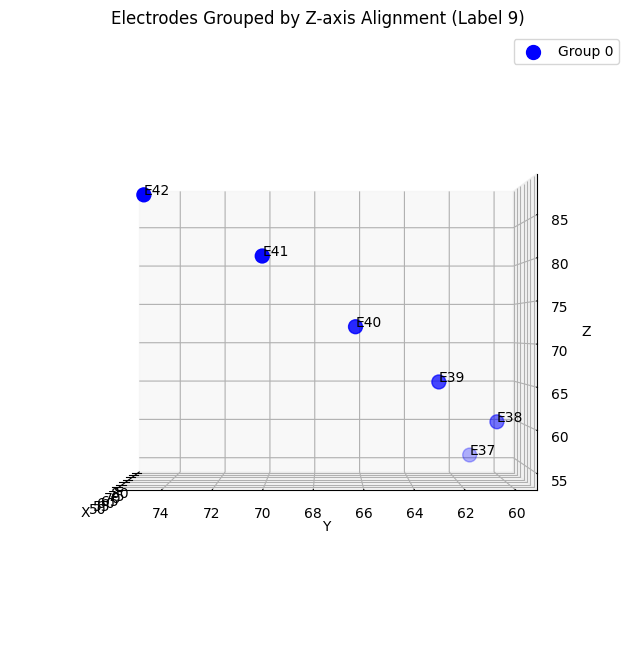

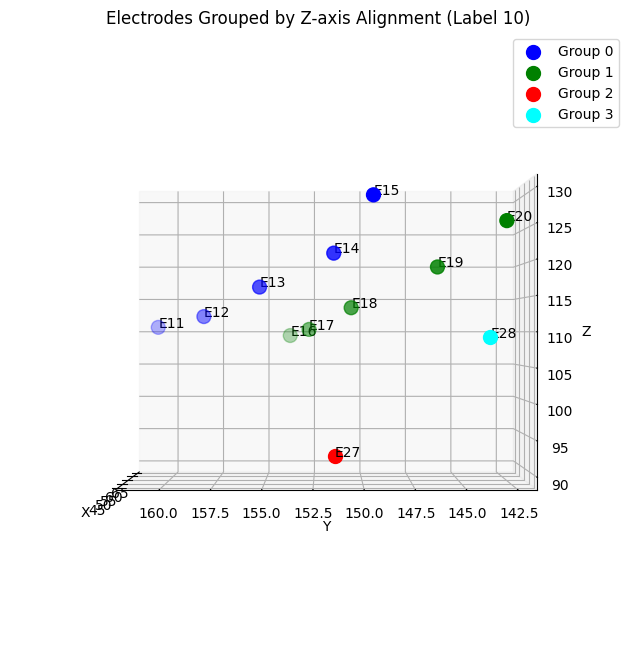

{'0': [[55, 56, 57, 58, 59], [60, 61, 62, 63, 64]],
 '1': [[43, 44, 97, 98, 99, 100],
  [105, 106, 107, 108],
  [113, 114, 115, 116, 117],
  [121, 122, 123, 124]],
 '2': [[35, 36], [45, 46, 47]],
 '3': [[65, 66, 67, 68], [73, 74, 75, 76], [81, 82, 83, 84], [89, 90, 91, 92]],
 '4': [[29, 30, 31, 32, 33, 34]],
 '5': [[101, 102, 103, 104], [109, 110, 111, 112], [118, 119, 120]],
 '6': [[48, 49, 50, 51, 52, 53, 54]],
 '7': [[69, 70, 71, 72], [77, 78, 79, 80], [85, 86, 87, 88], [93, 94, 95, 96]],
 '8': [[21, 22, 23], [24, 25, 26]],
 '9': [[37, 38, 39, 40, 41, 42]],
 '10': [[11, 12, 13, 14, 15], [16, 17, 18, 19, 20], [27], [28]]}

In [32]:
# electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_2024.csv")
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_electrodes_2024.csv")

# Find the range of labels
min_label = electrode_df['label'].min()
max_label = electrode_df['label'].max()

# Initialize the final dictionary to store electrode groups
electrode_groups = {}

# Loop through each label
for label in range(min_label, max_label + 1):
    # Filter the dataframe for the current label
    filtered_df = electrode_df[electrode_df['label'] == label]
    sorted_df = filtered_df.sort_values(by='electrode_number')


    # Calculate distances and define z_threshold as before
    distances = np.sqrt((np.diff(sorted_df['Z'])**2) + (np.diff(sorted_df['Y'])**2))
    Q1, Q3 = np.percentile(distances, [25, 75])
    IQR = Q3 - Q1
    filtered_distances = distances[(distances >= Q1 - 1.5 * IQR) & (distances <= Q3 + 1.5 * IQR)]
    z_threshold = np.mean(filtered_distances) + 5
    # print(np.mean(filtered_distances), z_threshold, 'threshold')

    # Initialize a group label and assign group labels
    group_label = 0
    sorted_df['group'] = -1  
    for i in range(len(sorted_df)):
        if i == 0:
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
        else:
            distance = np.sqrt((sorted_df.iloc[i]['Z'] - sorted_df.iloc[i-1]['Z'])**2 + (sorted_df.iloc[i]['Y'] - sorted_df.iloc[i-1]['Y'])**2)
            if distance > z_threshold:
                group_label += 1
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label


    # Visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=0, azim=180)

    unique_groups = sorted_df['group'].unique()
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
    for group in unique_groups:
        group_df = sorted_df[sorted_df['group'] == group]
        color = colors[unique_groups.tolist().index(group)]
        ax.scatter(group_df['X'], group_df['Y'], group_df['Z'], s=100, color=color, label=f'Group {group}')
        for _, row in group_df.iterrows():
            ax.text(row['X'], row['Y'], row['Z'], f"E{row['electrode_number']}", color='black')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(f'Electrodes Grouped by Z-axis Alignment (Label {label})')
    plt.legend()
    plt.show()
    
    # Group the electrodes by 'group' and collect electrode numbers in nested lists
    groups = sorted_df.groupby('group')['electrode_number'].apply(list).tolist()
    electrode_groups[str(label)] = groups  

# The electrode_groups dictionary now contains the required data
electrode_groups

